Finish training and validate on test data (print confusion matrix and report)

In [64]:
!pip install torchsummary

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [66]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import load

In [67]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [68]:
#dataset is available https://drive.google.com/drive/folders/1X9y3L07jEdIMA6mVPhWo0NKFJyWDfCuI?usp=drive_link
#you can

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
path = '/content/drive/MyDrive/'

In [70]:
import os

In [71]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset-20250210T052557Z-001/NA_Fish_Dataset'
clases = os.listdir(directory)

In [72]:
clases

['Red Sea Bream',
 'Trout',
 'Gilt Head Bream',
 'Shrimp',
 'Black Sea Sprat',
 'Striped Red Mullet',
 'Red Mullet',
 'Sea Bass',
 'Horse Mackerel']

In [73]:
clases = clases[:3]

In [74]:
clases

['Red Sea Bream', 'Trout', 'Gilt Head Bream']

In [75]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset-20250210T052557Z-001/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases:
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [76]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/NA_Fish_Dataset-2025021...,Red Sea Bream
1,/content/drive/MyDrive/NA_Fish_Dataset-2025021...,Red Sea Bream
2,/content/drive/MyDrive/NA_Fish_Dataset-2025021...,Red Sea Bream
3,/content/drive/MyDrive/NA_Fish_Dataset-2025021...,Red Sea Bream
4,/content/drive/MyDrive/NA_Fish_Dataset-2025021...,Red Sea Bream


In [77]:
len(df)

132

In [78]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 132/132 [00:02<00:00, 45.34it/s]


In [79]:
torch.cuda.is_available()

False

In [80]:
df.head()

,img,target
0,"[[[135, 105, 55], [140, 104, 65], [133, 104, 5...",Red Sea Bream
1,"[[[111, 92, 48], [111, 85, 49], [115, 83, 47],...",Red Sea Bream
2,"[[[117, 79, 38], [119, 77, 32], [130, 89, 44],...",Red Sea Bream
3,"[[[125, 102, 57], [121, 92, 55], [129, 106, 71...",Red Sea Bream
4,"[[[121, 90, 36], [119, 88, 37], [130, 89, 43],...",Red Sea Bream


In [81]:
df['target'].unique()

array(['Red Sea Bream', 'Trout', 'Gilt Head Bream'], dtype=object)

In [82]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [83]:
df.head()

,img,target
0,"[[[135, 105, 55], [140, 104, 65], [133, 104, 5...",Red Sea Bream
1,"[[[111, 92, 48], [111, 85, 49], [115, 83, 47],...",Red Sea Bream
2,"[[[117, 79, 38], [119, 77, 32], [130, 89, 44],...",Red Sea Bream
3,"[[[125, 102, 57], [121, 92, 55], [129, 106, 71...",Red Sea Bream
4,"[[[121, 90, 36], [119, 88, 37], [130, 89, 43],...",Red Sea Bream


In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [85]:
len(y_train)

105

In [86]:
len(y_test)

27

In [87]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [88]:
class MyConvNet(nn.Module):
    def __init__(self, num_classes):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Вычисленный размер после сверток и пулинга
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)  # Преобразование в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [89]:
if torch.cuda.is_available():
  net = MyConvNet().cuda()
else:
  net = MyConvNet(num_classes=3)

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

#net.forward(torch.FloatTensor(batch[0]))

torch.Size([4, 3, 256, 256])


In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [91]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.0596208484084517  test_loss  1.060398621218545
epoch  1  train_loss  1.0014769103791978  test_loss  1.0129838500704085
epoch  2  train_loss  0.9056300995526491  test_loss  0.9436021106583732
epoch  3  train_loss  0.7977992064423032  test_loss  0.8918513144765582
epoch  4  train_loss  0.6723345076596295  test_loss  0.8293091143880572
epoch  5  train_loss  0.5489959496038931  test_loss  0.7223873053278241
epoch  6  train_loss  0.44195880658096737  test_loss  0.6356053480080196
epoch  7  train_loss  0.3522735491946892  test_loss  0.5890341656548637
epoch  8  train_loss  0.27616900867886013  test_loss  0.5362207485096795
epoch  9  train_loss  0.22923043439233745  test_loss  0.5203991585544178


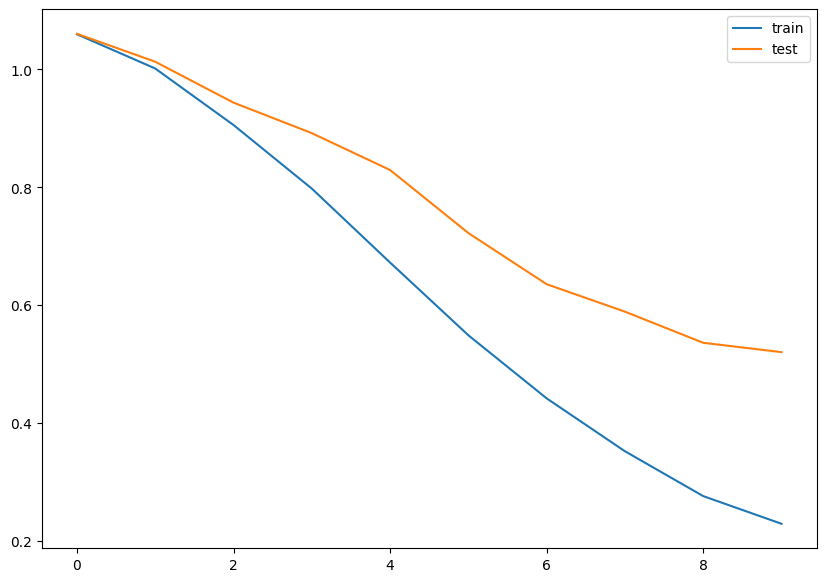

In [92]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [93]:
y_pred = []
#Test your model on X_test data and show confusion_matrix and classification_report

In [94]:
y_pred[:5]

[]

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

# Проверяем, есть ли предсказания в y_pred
if len(y_pred) == 0:
    y_pred = []
    net.eval()  # Переводим модель в режим предсказания
    with torch.no_grad():
        for batch in testloader:
            X_test_batch, y_true = batch
            X_test_batch = X_test_batch.to(device)
            outputs = net(X_test_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())  # Перекладываем предсказания в список

# Вычисляем метрики
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[8 0 4]
 [0 5 2]
 [0 0 8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       1.00      0.71      0.83         7
           2       0.57      1.00      0.73         8

    accuracy                           0.78        27
   macro avg       0.86      0.79      0.79        27
weighted avg       0.87      0.78      0.79        27



In [96]:
import os
print(os.listdir('/mnt/data/'))


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/'

In [97]:
image_path = '/mnt/data/image.png'  # Ensure this is the correct file name


In [98]:
import os

# Corrected path to the uploaded file
image_path = '/mnt/data/image.png'

# Check if file exists before proceeding
if not os.path.exists(image_path):
    print(f"Error: File '{image_path}' not found!")
else:
    # Function to predict a single image
    def predict_image(image_path, model, device):
        from PIL import Image
        import torch
        from torchvision import transforms

        # Load the image
        image = Image.open(image_path)

        # Preprocess the image (resize and convert to tensor)
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        image = transform(image).unsqueeze(0)  # Add batch dimension

        # Move the image to the same device as the model
        image = image.to(device)

        # Set the model to evaluation mode and make a prediction
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            output = model(image)
            _, predicted_class = torch.max(output, 1)  # Get the class with the highest probability

        # Return the predicted class
        return predicted_class.item()

    # Predict the image class
    predicted_class = predict_image(image_path, net, device)

    # Print the predicted class (convert numerical label back to the class name)
    print(f'Predicted class: {classes[predicted_class]}')


Error: File '/mnt/data/image.png' not found!


In [106]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Определяем список классов (должен соответствовать обучению)
classes = ['Red Sea Bream', 'Trout', 'Gilt Head Bream']

# Определяем преобразование (такое же, как при обучении)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Загружаем изображение
image_path = "/content/drive/MyDrive/NA_Fish_Dataset-20250210T052557Z-001/NA_Fish_Dataset/Trout/00001.png"
image = Image.open(image_path)
image = image.resize((256, 256))  # Приведение к размеру, который использовался при обучении
image = transform(image).unsqueeze(0)  # Добавляем размерность batch

# Перемещение изображения на тот же девайс, что и модель
image = image.to(device)

# Предсказание модели
net.eval()
with torch.no_grad():
    output = net(image)
    _, predicted = torch.max(output, 1)

# Перевод предсказанного индекса в название класса
predicted_class = classes[predicted.item()]

print(f"Предсказанный класс: {predicted_class}")


Предсказанный класс: Gilt Head Bream
